In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *

import torch 


In [15]:
def get_data_labels(csv,label):
    fileraw = pd.read_csv(csv)
    labels = fileraw[label].to_numpy()
    data = fileraw.drop([label],axis=1).to_numpy(dtype=np.float32).reshape((fileraw.shape[0],28,28))
    data = np.expand_dims(data, axis=1)
    return data, labels

In [16]:
DATAPATH = "/content/drive/My Drive/Colab Folder/kannada MNIST/"

train_data, train_labels = get_data_labels(DATAPATH+'train.csv','label')
test_data, test_labels = get_data_labels(DATAPATH+'test.csv','id')
other_data, other_labels = get_data_labels(DATAPATH+'Dig-MNIST.csv','label')

In [17]:
print(f' Train:\tdata shape {train_data.shape}\tlabel shape {train_labels.shape}\n \
Test:\tdata shape {test_data.shape}\tlabel shape {test_labels.shape}\n \
Other:\tdata shape {other_data.shape}\tlabel shape {other_labels.shape}')

 Train:	data shape (60000, 1, 28, 28)	label shape (60000,)
 Test:	data shape (5000, 1, 28, 28)	label shape (5000,)
 Other:	data shape (10240, 1, 28, 28)	label shape (10240,)


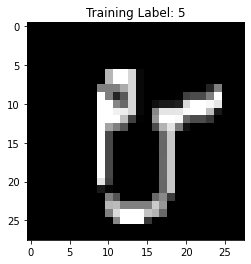

In [18]:
plt.title(f'Training Label: {train_labels[5]}')
plt.imshow(train_data[8,0],cmap='gray')

In [19]:
np.random.seed(60)
#np.random.randint(low = 0, high = 255, size = 1)

ran_10_pct_idx = (np.random.random_sample(train_labels.shape)) < .001

train_90_labels = train_labels[np.invert(ran_10_pct_idx)]
train_90_data = train_data[np.invert(ran_10_pct_idx)]

valid_10_labels = train_labels[ran_10_pct_idx]
valid_10_data = train_data[ran_10_pct_idx]

In [20]:
class ArrayDataset(Dataset):
    "Dataset for numpy arrays based on fastai example: "
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = len(np.unique(y))
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
        

In [21]:
train_ds = ArrayDataset(train_90_data,train_90_labels)
valid_ds = ArrayDataset(valid_10_data,valid_10_labels)
other_ds = ArrayDataset(other_data, other_labels)
test_ds = ArrayDataset(test_data, test_labels)

In [22]:
bs = 256
databunch = DataBunch.create(train_ds, valid_ds, test_ds=test_ds, bs=bs)

In [23]:
def conv2(ni,nf,stride=2,ks=5): return conv_layer(ni,nf,stride=stride,ks=ks)

In [24]:
best_architecture = nn.Sequential(
    conv2(1,32,stride=1,ks=5),
    conv2(32,32,stride=1,ks=5),
    conv2(32,32,stride=2,ks=8),
    nn.Dropout(0.4),
    
    conv2(32,64,stride=1,ks=5),
    conv2(64,64,stride=1,ks=5),
    conv2(64,64,stride=2,ks=5),
    nn.Dropout(0.4),
    
    Flatten(),
    nn.Linear(3136, 256),
    relu(inplace=True),
    nn.BatchNorm1d(256),
    nn.Dropout(0.4),
    nn.Linear(256,10)
)


In [25]:
learn = Learner(databunch, best_architecture, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy] )

In [26]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.097547,0.028372,0.980392,00:10
1,0.039171,0.031337,0.980392,00:10
2,0.034306,0.000394,1.000000,00:10
3,0.024515,0.040443,0.980392,00:10
4,0.020001,0.001241,1.000000,00:10
5,0.014998,0.000119,1.000000,00:10
6,0.010829,0.000085,1.000000,00:10
7,0.006235,0.000096,1.000000,00:10
8,0.003128,0.000021,1.000000,00:10
9,0.002617,0.000012,1.000000,00:10


In [33]:
torch.save(best_architecture.state_dict(), "/content/drive/My Drive/Colab Folder/kannada MNIST/kannada_fastai.sh")


In [28]:
preds, ids = learn.get_preds(DatasetType.Test)
y = torch.argmax(preds, dim=1)

In [29]:
y

tensor([3, 0, 2,  ..., 1, 6, 3])

In [30]:
submission = pd.DataFrame({ 'id': ids,'label': y })
submission.to_csv(path_or_buf ="submission.csv", index=False)

In [31]:
df = pd.read_csv("/content/submission.csv")
df

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,6
